# Progetto big data

## 1. Inizializzazione
* pre-requisiti: file csv suddiviso tassonomicamente (e.g: "skill-Linux") e un blocco ID (e.g:"ID-name")
* venv con librerie

### 1.1 librerie e API

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *

import pandas as pd
import numpy as np

from collections import Counter
from langchain_community.document_loaders import PySparkDataFrameLoader
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain

import os
import json

import openai
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



inserire la propria api key

In [ ]:
openai.api_key = ""

### 1.2 creazione spark 

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Il mio primo progetto Spark") \
    .getOrCreate()


## 2. apertura csv e lettura 
cambiare il csv se necessario

In [5]:
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("populated_matrix.csv")

#prende il nome delle colonne
columns = df.columns

stampa numero user e feature

In [ ]:
num_columns = len(df.columns)
num_rows = df.count()

print(f"Number of columns (features): {num_columns}")
print(f"Number of rows (users): {num_rows}")


Number of columns (features): 129
Number of rows (users): 2104


## 3 blocchi tematici

In [7]:
#Estrarre il blocco da ogni colonna
thematic_blocks = [col.split('-', 1)[0] for col in columns]  #prendi la parte prima del primo '-'

#Contare le ricorrenze di ogni blocco
counts = Counter(thematic_blocks)

print("Numero di blocchi tematici distinti:", len(counts))
for block, freq in counts.items():
    print(f"{block} -> {freq} colonne")

#Costruisci un dizionario di blocchi {nome_blocco: [colonna1, colonna2, ...]}
blocks_dict = {}
for col in columns:
    block_name = col.split('-', 1)[0]
    if block_name not in blocks_dict:
        blocks_dict[block_name] = []
    blocks_dict[block_name].append(col)

#print
print("Struttura dei blocchi estratti dinamicamente:")
print(json.dumps(blocks_dict, indent=2))

Numero di blocchi tematici distinti: 8
ID -> 2 colonne
work_activities -> 9 colonne
knowledge -> 15 colonne
tools -> 16 colonne
tech_skills -> 39 colonne
abilities -> 8 colonne
tasks -> 26 colonne
skills -> 14 colonne
Struttura dei blocchi estratti dinamicamente:
{
  "ID": [
    "ID-ID",
    "ID-name"
  ],
  "work_activities": [
    "work_activities-Resolving Conflicts and Negotiating with Others",
    "work_activities-Evaluating Information to Determine Compliance with Standards",
    "work_activities-Processing Information",
    "work_activities-Developing Objectives and Strategies",
    "work_activities-Establishing and Maintaining Interpersonal Relationships",
    "work_activities-Making Decisions and Solving Problems",
    "work_activities-Thinking Creatively",
    "work_activities-Getting Information",
    "work_activities-Training and Teaching Others"
  ],
  "knowledge": [
    "knowledge-Customer and Personal Service",
    "knowledge-Design",
    "knowledge-Production and Proces

## 4 LLM-Query

### 4.1 parsing query con gpt

In [8]:
def parse_user_query_strict(query, blocks_dictionary):
    """
    Usa GPT per analizzare la query dell'utente e identificare 
    quali blocchi e/o feature potrebbero essere rilevanti,
    assegnando anche un peso (0-1) a ciascuna feature/blocco.

    Restituisce un dizionario con la struttura:
    {
      "relevant_blocks": [
        {
          "block_name": "NomeBlocco",
          "weight": 0.8
        }
      ],
      "relevant_features": [
        {
          "name": "NomeColonna",
          "weight": 1.0
        }
      ]
    }
    """
    import json
    import openai

    # Prompt per GPT: chiediamo di essere molto selettivi,
    # aggiungendo una richiesta di weight da 0 a 1.
    prompt = f"""
    Devi analizzare la query di un utente su un dataset di skill,
    DIVISO IN BLOCCHI, ognuno con diverse colonne (feature).
    Ecco la struttura (blocks_dictionary) in JSON:
    {json.dumps(blocks_dictionary, indent=2)}

    L'utente fa la seguente richiesta: "{query}"

    *SII MOLTO SELETTIVO*:
    - Se la colonna o il blocco non è strettamente correlato alla richiesta, NON includerlo.
    - Se ritieni che l'utente voglia TUTTO il blocco, allora aggiungi un oggetto in "relevant_blocks"
      con {{"block_name": "NomeBlocco", "weight": <valore 0-1>}}.
    - Se invece l'utente è interessato a UNA o POCHI argomenti all'interno di un blocco,
      indica le feature (colonne) specifiche in "relevant_features", 
      con {{"name": "NomeColonna", "weight": <valore 0-1>}}.
    - Non aggiungere nulla che non sia chiaramente correlato alla query.
    - Se una skill è più importante, assegnale un peso più alto (vicino a 1).
      Se è rilevante ma secondaria, peso intermedio (0.3-0.7).
    - Restituisci SOLO un JSON **valido** con questa struttura:
    {{
      "relevant_blocks": [
        {{
          "block_name": "NomeBlocco",
          "weight": 0.8
        }}
      ],
      "relevant_features": [
        {{
          "name": "NomeColonna",
          "weight": 1.0
        }}
      ]
    }}
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "Sei un assistente che analizza la query dell'utente "
                        "per trovare i blocchi e/o le feature più rilevanti, "
                        "assegnando pesi (0-1) in modo selettivo."
                    )
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.0
        )
        content = response["choices"][0]["message"]["content"]
        parsed_json = json.loads(content)  
        return parsed_json
    except (json.JSONDecodeError, KeyError):
        return {
            "relevant_blocks": [],
            "relevant_features": []
        }
    except Exception as e:
        print("Errore inaspettato nella chiamata a GPT:", e)
        return {
            "relevant_blocks": [],
            "relevant_features": []
        }


### 4.2 funzione colonne corrispondenti
* prende l'elenco di blocchi tematici e delle feature
* crea un set nuovo
* controlla se GPT indica un blocco o una o più feature e l'aggiunge nel set restituendola
* se viene richiesto tutto un blocco si assegnerà tutto quel blocco, sennò solo delle feature specifiche

In [9]:

def find_relevant_columns(parsed_dict, blocks_dictionary):
    """
    Dati i blocchi/feature con relativi pesi (da 0 a 1),
    costruisce un dizionario {colonna: peso} da selezionare.

    Logica invariata nella selezione (molto severa), con la differenza
    che i relevant_blocks e relevant_features sono liste di oggetti:
      { "block_name": "...", "weight": ... }
      { "name": "...",        "weight": ... }
    
    - Se GPT include un blocco in 'relevant_blocks' ma specifica anche alcune feature
      di quel blocco in 'relevant_features', prendiamo SOLO quelle feature.
    - Se GPT include un blocco (weight=W) e non specifica feature particolari,
      includiamo TUTTO il blocco con peso=W.
    - Se GPT specifica feature di un blocco che non compare in 'relevant_blocks',
      includiamo solo quelle feature con i loro pesi.
    """

    relevant_blocks = parsed_dict.get("relevant_blocks", [])
    relevant_feats = parsed_dict.get("relevant_features", [])

    #Costruiamo un dict: block_name -> weight
    block_weights = {}
    for b in relevant_blocks:
        bname = b.get("block_name")
        w = b.get("weight", 0.5)  # default 0.5 se non presente
        if bname and bname in blocks_dictionary:
            block_weights[bname] = w

    #Costruiamo un dict: feature_name -> weight
    feature_weights = {}
    for f in relevant_feats:
        fname = f.get("name")
        w = f.get("weight", 0.5)
        if fname:
            feature_weights[fname] = w

    #Iniziamo a costruire un dict finale col -> peso
    final_col_weights = {}

    # 1) Se un blocco è elencato, ma GPT ha specificato feature di quel blocco
    #    usiamo solo quelle feature con i loro pesi.
    #    altrimenti, includiamo tutto il blocco con lo stesso peso di blocco.
    for block_name, wblock in block_weights.items():
        # Verifichiamo se ci sono feature di questo blocco
        block_specific_feats = []
        for feat_name, wfeat in feature_weights.items():
            
            # verifichiamo se feat_name appartiene al blocco in blocks_dictionary
            cols_in_block = blocks_dictionary.get(block_name, [])
            if feat_name in cols_in_block:
                block_specific_feats.append((feat_name, wfeat))

        if len(block_specific_feats) > 0:
            # Abbiamo feature specifiche quindi aggiungiamo solo quelle
            for (colname, colweight) in block_specific_feats:
                final_col_weights[colname] = colweight
        else:
            # Nessuna feature specifica, allora includi tutto il blocco
            for col in blocks_dictionary.get(block_name, []):
                final_col_weights[col] = wblock

    # 2) Gestione di feature non citate in relevant_blocks (o citate fuori blocco)
    #       se GPT ha messo per qualche feature (f.name, f.weight) e
    #       il block non è in block_weights, la aggiungiamo lo stesso
    for feat_name, wfeat in feature_weights.items():
        # se non l'abbiamo già inserita
        if feat_name not in final_col_weights:
            final_col_weights[feat_name] = wfeat

    # Stampa a video le feature trovate e il relativo peso
    print("Feature (o colonne) trovate da GPT con peso:")
    for col, w in final_col_weights.items():
        print(f"  - {col} -> {w}")

    return final_col_weights


### 4.3 richiesta query ed esecuzione operazione 
* l'utente inserisce se vuole usare un operatore "AND" (quindi verranno restituiti tutti gli utenti che rispettano tutte le condizioni)
* oppure un "NOR" (qualsiasi utente abbia almeno una di quelle skill)

In [29]:
user_query = input("Inserisci la query: ")

#Analisi della query con GPT
parsed_result = parse_user_query_strict(user_query, blocks_dict)

#Ottengo un dizionario {colonna: peso} invece di una semplice lista
col_weights_dict = find_relevant_columns(parsed_result, blocks_dict)

#Se non c'è alcuna colonna, GPT non ha trovato corrispondenze
if len(col_weights_dict) == 0:
    print("Nessuna feature trovata da GPT (o GPT non è sicuro).")

    # Mostra solo ID
    id_block_columns = blocks_dict.get("ID", [])
    df.select(id_block_columns).show(truncate=False)
else:
    #Aggiungiamo all'inizio la presenza di tutte le colonne del blocco "ID" 
    id_block_columns = blocks_dict.get("ID", [])
    final_columns_with_weights = {}

    #Inserisci ID con peso speciale (nullo)
    for col_id in id_block_columns:
        if col_id in df.columns:
            final_columns_with_weights[col_id] = None 

    #Aggiungiamo le colonne GPT trovate (col->weight) 
    for c, w in col_weights_dict.items():
        if c in df.columns:
            final_columns_with_weights[c] = w

    #Ordina le colonne:
    #    - prima ID in ordine in cui compaiono
    #    - poi le skill 
    id_cols = list(final_columns_with_weights.keys())[:len(id_block_columns)]  #i primi len(id_block_columns) sono ID
    skill_cols_and_weights = [(c, w) for c, w in final_columns_with_weights.items() if w is not None]
    skill_cols_and_weights.sort(key=lambda x: x[1], reverse=True)

    #costruiamo la lista finale di colonne
    final_columns = id_cols + [x[0] for x in skill_cols_and_weights]

    print("Colonne finali da selezionare (ID + skill ordinate per peso):", final_columns)


    #Filtro con Spark: prendi gli utenti che hanno almeno una skill = 1 tra quelle scelte
    skill_only_columns = [x[0] for x in skill_cols_and_weights]
    if skill_only_columns:
        #Crea condizioni NOR solo se ci sono skill
        filter_conditions = [F.col(c) == 1 for c in skill_only_columns]
        combined_filter = reduce(Column.__or__, filter_conditions)
        df_filtered = df.filter(combined_filter).select(final_columns)
    else:
        #Se non ci sono skill, seleziona solo ID senza filtrare
        df_filtered = df.select(final_columns)

Feature (o colonne) trovate da GPT con peso:
  - knowledge-English Language -> 1.0
  - knowledge-Foreign Language -> 1.0
  - knowledge-Fine Arts -> 0.7
  - tech_skills-Linux -> 0.7
  - abilities-Far Vision -> 0.5
  - abilities-Near Vision -> 0.5
  - tech_skills-After the Deadline -> 0.3
  - skills-Complex Problem Solving -> 0.3
  - skills-Operations Analysis -> 0.3
Colonne finali da selezionare (ID + skill ordinate per peso): ['ID-ID', 'ID-name', 'knowledge-English Language', 'knowledge-Foreign Language', 'knowledge-Fine Arts', 'tech_skills-Linux', 'abilities-Far Vision', 'abilities-Near Vision', 'tech_skills-After the Deadline', 'skills-Complex Problem Solving', 'skills-Operations Analysis']


In [30]:
#stampa query utente
print(user_query)

individuami chiunque sappia l'inglese o un'altra lingua, apprezzato  chi conosca le belle arti o linux e abbia abilità fisiche, non importante ma considera chiunque sappia lavorare con deadline o abbia buone capacità di organizzarsi


### 4.4 salvare i risultati in un dataset pandas

In [31]:
def convert_spark_to_pandas(spark_df):
    columns = spark_df.columns
    data = []
    for row in spark_df.collect():
        data.append(row.asDict())
    return pd.DataFrame(data, columns=columns)

In [32]:
pdf = convert_spark_to_pandas(df_filtered)

# 2) Calcolo punteggio pesato
weighted_scores = []
for idx, row in pdf.iterrows():
    score = 0.0
    for col in skill_only_columns:
        skill_value = row[col]  # 0 o 1
        weight = col_weights_dict.get(col, 0)
        score += skill_value * weight
    weighted_scores.append(score)

pdf['weighted_score'] = weighted_scores

# 3) Ordiniamo i dati in base al punteggio pesato
pdf_sorted = pdf.sort_values('weighted_score', ascending=False)

# 4) Rimuove l'ultima colonna da pdf_sorted
pdf_sorted.drop(columns=[pdf_sorted.columns[-1]], inplace=True)

# Creiamo una mappa "peso → frazione" per usare un unico colore per colonne con lo stesso peso
unique_weights = sorted({col_weights_dict.get(c, 0) for c in skill_only_columns})
if len(unique_weights) > 1:
    min_w, max_w = unique_weights[0], unique_weights[-1]
    weight_to_fraction = {
        w: (w - min_w) / (max_w - min_w)
        for w in unique_weights
    }
else:
    # Se esiste un solo peso (o nessuno), assegniamo una frazione fissa
    weight_to_fraction = {w: 0.5 for w in unique_weights}

## 5. Rank utenti e visualizzazione grafici
* elenca gli utenti, quelli con più skill saranno nei primi posti
* crea una "heatmap" ibrida per interpretare meglio i dati
* restituisce dei grafici a torta

### 5.1 tabella con heatmap

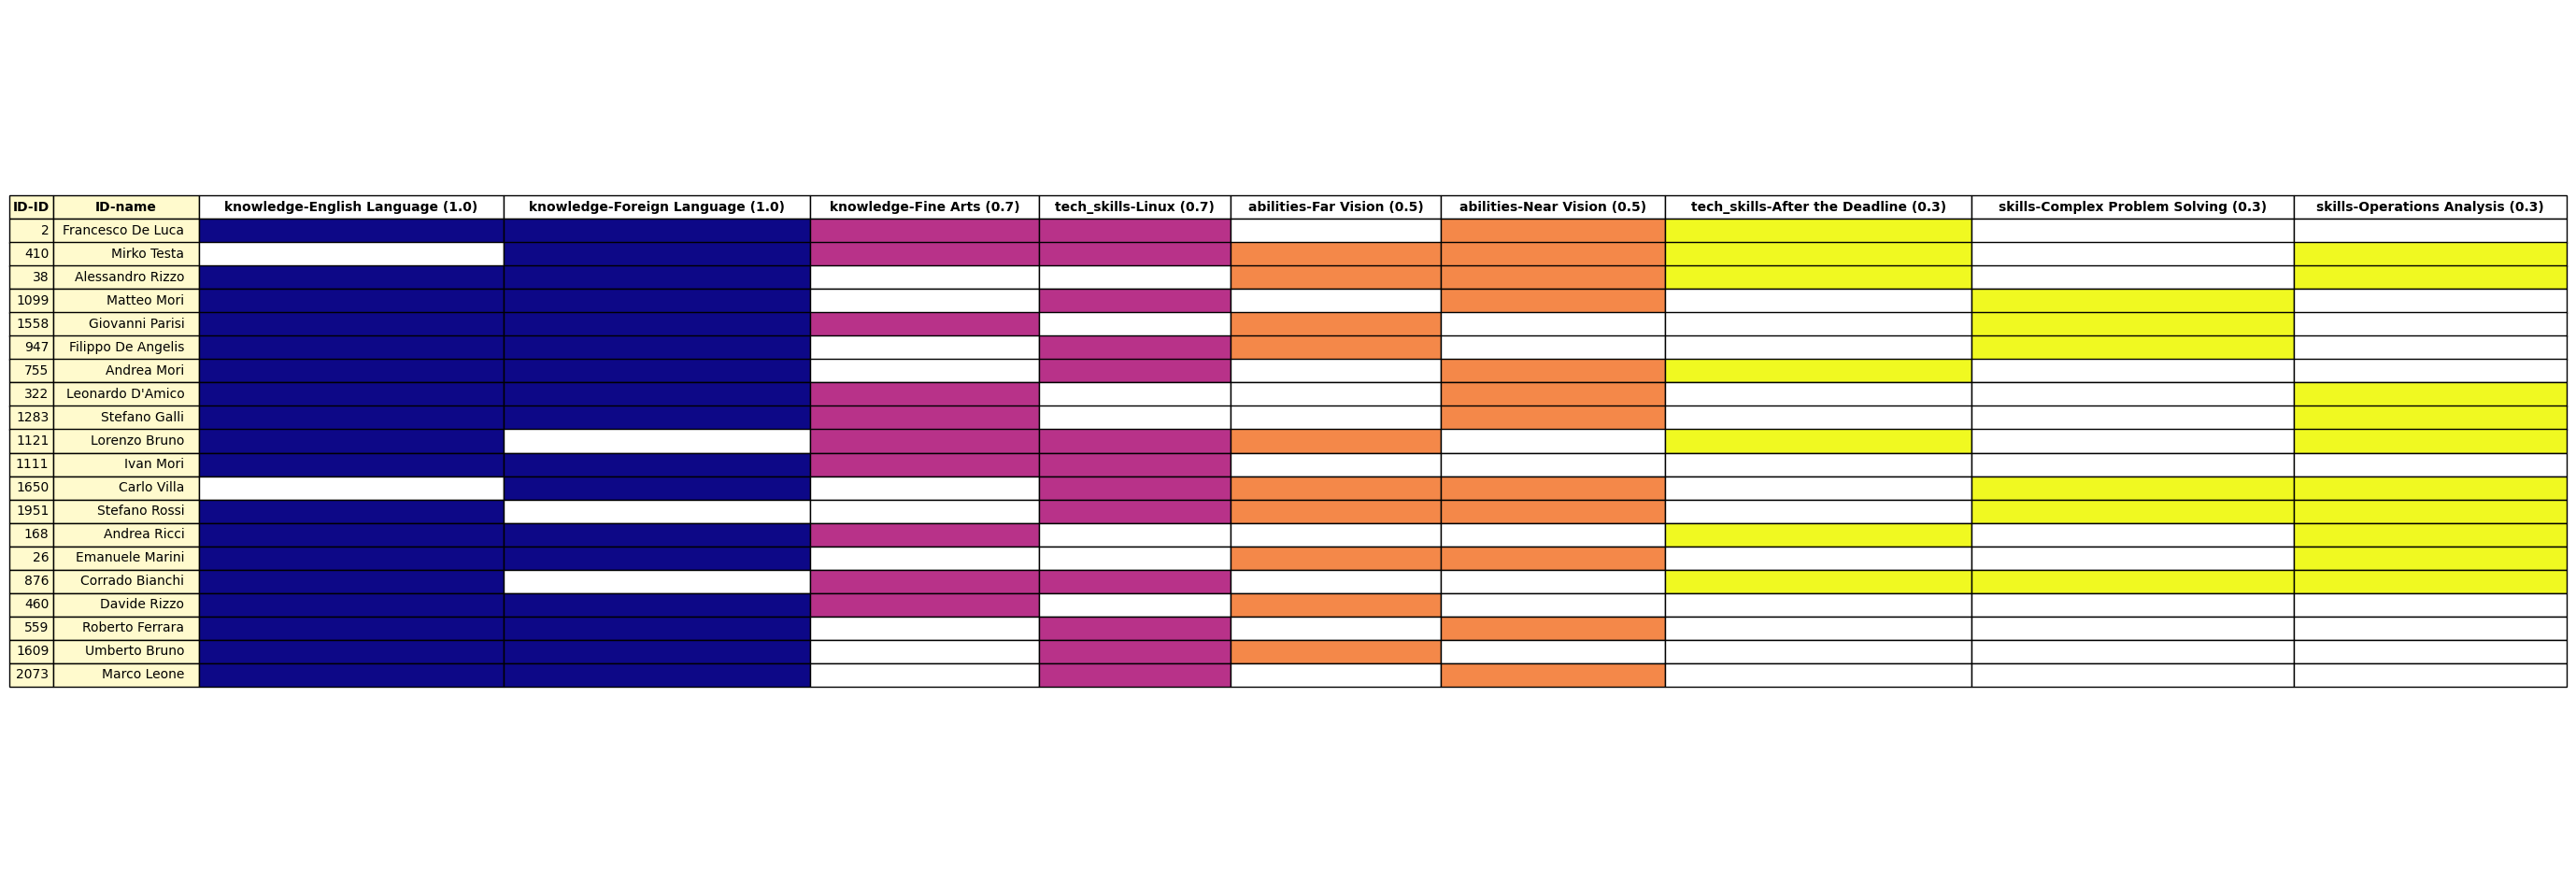

In [33]:

pdf_table = pdf_sorted.copy()  # Cloniamo pdf_sorted

num_users = len(pdf_table)
scelta = input(f"Ci sono {num_users} utenti, quanti ne vuoi visualizzare? (inserisci un numero o 'tutti'): ")

if scelta.lower() == 'tutti':
    # Non applichiamo filtri, pdf_table rimane intatto
    pass
else:
    try:
        n = int(scelta)
        # Se l'utente inserisce un numero maggiore del totale utenti, mostriamo comunque tutti
        if n > num_users:
            n = num_users
        pdf_table = pdf_table.head(n)
    except ValueError:
        # Se l'input non è un numero, mostriamo a prescindere tutti gli utenti
        print("Input non valido, mostro tutti gli utenti:")

# Se dopo la selezione il DataFrame è vuoto, segnaliamo che non ci sono utenti
if pdf_table.empty:
    print("Non ci sono utenti da visualizzare.")

# -----------------------------------------------------------------------------
# Creazione della tabella basata su pdf_table 
# -----------------------------------------------------------------------------

# Creiamo la figura e l'axes
fig, ax = plt.subplots(figsize=(14, 0.6 * len(pdf_table)))
ax.axis('off')

# Creiamo nuove etichette per le colonne che includono anche il peso
new_col_labels = []
for col in pdf_table.columns:
    if col.startswith("ID-"):
        # Niente peso nell'etichetta
        new_col_labels.append(col)
    else:
        w = col_weights_dict.get(col, 0)
        new_col_labels.append(f"{col} ({w})")

# Generiamo la tabella
table = ax.table(
    cellText=pdf_table.values.astype(str),
    colLabels=new_col_labels,
    loc='center'
)

# Header in grassetto e dimensione font
for col_index, label in enumerate(pdf_table.columns):
    cell_header = table.get_celld()[(0, col_index)]
    cell_header.get_text().set_weight('bold')
    cell_header.set_fontsize(10)
    
    # Colora l'header solo delle colonne "ID-"
    if label.strip().startswith("ID-"):
        cell_header.set_facecolor('LemonChiffon')

# Aumentiamo la dimensione delle celle 
table.scale(1.5, 1.5)

# Otteniamo numero di righe e di colonne 
nrows = len(pdf_table)
ncols = len(pdf_table.columns)

# Colormap desiderata
cmap = plt.get_cmap('plasma')

# Ciclo sulle righe (partiamo da uno perché la riga 0 è l'header)
for i in range(nrows):
    for j in range(ncols):
        cell = table.get_celld()[(i + 1, j)]
        val_str = pdf_table.iloc[i, j]

        # Verifichiamo se il nome colonna inizia con "ID-"
        if pdf_table.columns[j].strip().startswith("ID-"):
            cell.set_facecolor('LemonChiffon')
            continue

        # Proviamo a convertire in float per controllarne il valore
        try:
            val = float(val_str)
        except ValueError:
            # Se non è convertibile in float, la lasciamo bianca
            cell.set_facecolor('white')
            continue

        if pd.isna(val) or val == 0.0:
            # Se 0 o NaN => cella bianca
            cell.set_facecolor('white')
            cell.get_text().set_text('')
        else:
            # Recuperiamo il peso di questa colonna
            col_name = pdf_table.columns[j]
            w = col_weights_dict.get(col_name, 0)

            # Calcoliamo la frazione associata a questo peso
            fraction = weight_to_fraction.get(w, 0.0)
            color = cmap(1 - fraction)
            cell.set_facecolor(color)
            cell.get_text().set_text('')

table.auto_set_column_width(col=list(range(ncols)))

plt.show()

### 5.2 barplot frequenze

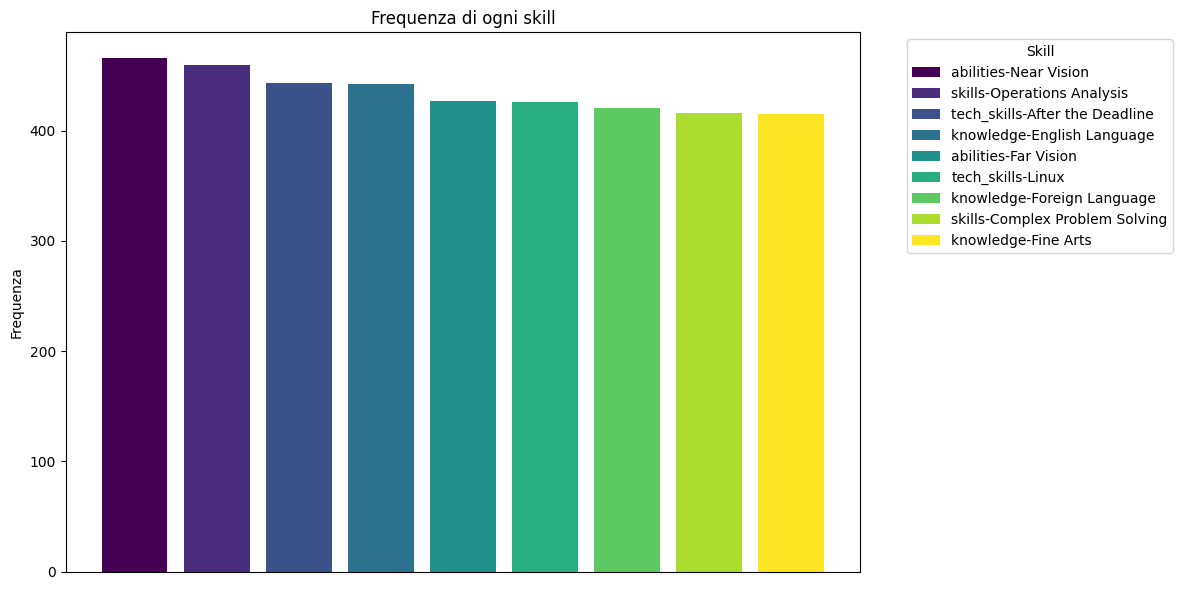

In [34]:
#Calcoliamo la frequenza di ogni skill come somma dei valori 1 per colonna
skill_sums = pdf_sorted[skill_only_columns].sum()

#Ordiniamo le skill in base alla loro frequenza in modo decrescente
sorted_skill_sums = skill_sums.sort_values(ascending=False)

#Creiamo una palette di colori usando 'viridis' in base al numero di skill
bar_colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_skill_sums)))

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_skill_sums.index, sorted_skill_sums.values, color=bar_colors)

#Impostiamo l'etichetta di ogni barra
for bar, skill in zip(bars, sorted_skill_sums.index):
    bar.set_label(skill)

plt.xticks([])

# Aggiungiamo la legenda a destra
plt.legend(title='Skill', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Frequenza di ogni skill")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()


## 6 tkinter
* crea un svg con lo stesso ordinamento simile alla tabella precedente (5.1) ma senza nomi di colonne e righe, favorendone una compressione in "pixel" per favorirne la visualizzazione in caso di molti dati

In [36]:
import html
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog

#dimensione pixel
PIXEL_SIZE = 15  
cmap = plt.get_cmap('plasma')

#colore in base al peso
def weight_to_hex_color(w, weight_to_fraction):
    fraction = weight_to_fraction.get(w, 0.0)
    rgba = cmap(1.0 - fraction)
    return f"rgb({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)})"

#creazione svg on click
def generate_interactive_svg(pdf, skills, col_weights, weight_to_fraction, pixel_size=PIXEL_SIZE):
    width = len(skills) * pixel_size
    height = len(pdf) * pixel_size
    svg_content = [
        f'<svg width="{width}" height="{height}" viewBox="0 0 {width} {height}" xmlns="http://www.w3.org/2000/svg">\n'
        f'<rect x="0" y="0" width="{width}" height="{height}" fill="white"/>\n'
        '<script type="text/javascript"><![CDATA[\n'
        'function showUserInfo(userData, skill) {\n'
        '  let info = `Skill: ${skill}\\n`;\n'
        '  Object.entries(userData).forEach(([key, value]) => {\n'
        '    info += `${key}: ${value}\\n`;\n'
        '  });\n'
        '  alert(info);\n'
        '}\n'
        ']]></script>'
    ]

    for row_idx, (_, row) in enumerate(pdf.iterrows()):
        for col_idx, skill_name in enumerate(skills):
            if row[skill_name] == 1:
                w = col_weights.get(skill_name, 0.0)
                color = weight_to_hex_color(w, weight_to_fraction)
                x = col_idx * pixel_size
                y = row_idx * pixel_size
                user_data = {str(k): str(v) for k, v in row.items()}
                user_data_json = json.dumps(user_data, ensure_ascii=False)
                skill_json = json.dumps(skill_name, ensure_ascii=False)
                escaped_user_data_json = html.escape(user_data_json, quote=True)
                escaped_skill_json = html.escape(skill_json, quote=True)

                svg_content.append(
                    f'<rect x="{x}" y="{y}" width="{pixel_size}" height="{pixel_size}" '
                    f'fill="{color}" stroke="none" '
                    f'onclick="showUserInfo({escaped_user_data_json}, {escaped_skill_json})"/>'
                )

    svg_content.append('</svg>')
    return '\n'.join(svg_content)

choice = int(input(
    "Vuoi modificare il grafico? Inserisci:\n"
    "- 0 se vuoi visualizzare il grafico per intero\n"
    "- 1 se vuoi eliminare feature\n"
    "- 2 se vuoi visualizzare meno utenti\n"
    "- 3 se vuoi eliminare feature e visualizzare meno utenti\n"
    "Scegli un'opzione: "
).strip())

if choice == 1 or choice == 3:
    # Costruisci il messaggio delle feature disponibili
    features_filtrate = [col for col in skill_only_columns if not col.lower().startswith("id")]
    message = "Elenco feature disponibili per la rimozione:\n0. Nessuna\n"
    message += "\n".join(f"{idx}. {feat}" for idx, feat in enumerate(features_filtrate, start=1))
    to_remove_str = input(
        f"{message}\nInserisci gli indici delle feature da rimuovere, separati da virgola (esempio: 1,2,5): "
    )
    indices_to_remove = [int(x.strip()) for x in to_remove_str.split(",") if x.strip().isdigit()]
    if 0 not in indices_to_remove:
        feature_da_rimuovere = [features_filtrate[i - 1] for i in indices_to_remove if 1 <= i <= len(features_filtrate)]
        skill_only_columns[:] = [col for col in skill_only_columns if col not in feature_da_rimuovere]
        pdf_sorted.drop(columns=feature_da_rimuovere, errors='ignore', inplace=True)


if choice == 2 or choice == 3:
    #mostra meno utenti
    total_users = len(pdf_sorted)
    user_input = input("Ci sono {} utenti, quanti ne vuoi visualizzare? inserisci 'tutti' se vuoi visualizzarli tutti:".format(total_users)).strip().lower()
    if user_input != 'tutti':
        try:
            num_users = int(user_input)
            pdf_sorted = pdf_sorted.head(num_users)
        except ValueError:
            print("Inserimento non valido, verranno visualizzati tutti gli utenti.")

#crea il svg
svg_output = generate_interactive_svg(
    pdf_sorted,
    skill_only_columns,
    col_weights_dict,
    weight_to_fraction
)

#salva il file
with open("interactive_pixels.svg", "w") as f:
    f.write(svg_output)

#Jupyter notebook display
#display(HTML(svg_output))
    